# Final Models Comparison: Binary vs Multi-class Classification

## Objective
Compare the performance of simplified Binary Classification (Risk Triage) vs. Complex Multi-class Classification (Outcome Prediction) to determine which better serves student support.

## CRISP-DM Stage
Evaluation and Deployment

## Key Comparisons
1. **Model Performance**: Metrics comparison with focus on Recall for "At Risk" students
2. **Cluster Validation**: Do behavioral clusters correlate with failure rates?
3. **Actionability**: Which model better supports early intervention?

## Section 0: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, f1_score, recall_score, precision_score
)

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('All libraries imported successfully')
print('=' * 80)

All libraries imported successfully


## Section 1: Load Models and Data

In [2]:
print('\n' + '=' * 80)
print('LOADING CLASSIFICATION MODELS AND DATA')
print('=' * 80)

# Load best binary classification model
try:
    best_binary_model = pickle.load(open('../2_Outputs/best_binary_classification_model.pkl', 'rb'))
    print('✓ Binary Classification Model loaded')
except:
    print('⚠ Binary Classification Model not found - please run 02c_Binary_Classification_Models.ipynb')
    best_binary_model = None

# Load best multiclass classification model
try:
    best_multiclass_model = pickle.load(open('../2_Outputs/best_classification_model.pkl', 'rb'))
    print('✓ Multi-class Classification Model loaded')
except:
    print('⚠ Multi-class Classification Model not found - please run 02b_Classification_Models.ipynb')
    best_multiclass_model = None

# Load data and targets
df_encoded = pd.read_pickle('../2_Outputs/df_encoded_full.pkl')
features = pd.read_pickle('../2_Outputs/features_prepared.pkl')

# Load both targets
try:
    y_binary = pd.read_pickle('../2_Outputs/target_binary.pkl')
    print('✓ Binary target loaded')
except:
    y_binary = None
    print('⚠ Binary target not found')

try:
    y_multiclass = pd.read_pickle('../2_Outputs/target_multiclass.pkl')
    print('✓ Multi-class target loaded')
except:
    y_multiclass = None
    print('⚠ Multi-class target not found')

print(f'\nData shapes:')
print(f'  Features: {features.shape}')
print(f'  Binary target: {y_binary.shape if y_binary is not None else "Not available"}')
print(f'  Multi-class target: {y_multiclass.shape if y_multiclass is not None else "Not available"}')


LOADING CLASSIFICATION MODELS AND DATA
✓ Binary Classification Model loaded
✓ Multi-class Classification Model loaded
✓ Binary target loaded
✓ Multi-class target loaded

Data shapes:
  Features: (32593, 46)
  Binary target: (32593,)
  Multi-class target: (32593,)


## Section 2: Comparison 1 - Binary vs Multi-class Model Performance

**Question**: Does the simplified Binary model offer better Recall for "At Risk" students than the complex Multi-class model?

In [3]:
print('\n' + '=' * 80)
print('COMPARISON 1: BINARY vs MULTI-CLASS MODEL PERFORMANCE')
print('=' * 80)

if best_binary_model is not None and best_multiclass_model is not None:
    # Get predictions
    y_binary_pred = best_binary_model.predict(features)
    y_binary_proba = best_binary_model.predict_proba(features)[:, 1]
    
    y_multiclass_pred = best_multiclass_model.predict(features)
    # For binary comparison, convert multi-class (0=Distinction, 1=Pass, 2=Fail, 3=Withdrawn) to binary (0=Pass/Distinction, 1=Fail/Withdrawn)
    y_multiclass_as_binary = (y_multiclass_pred >= 2).astype(int)
    y_multiclass_proba = best_multiclass_model.predict_proba(features)
    y_multiclass_proba_at_risk = y_multiclass_proba[:, 2] + y_multiclass_proba[:, 3]  # Prob of Fail + Withdrawn
    
    print('\n' + '-' * 80)
    print('BINARY CLASSIFICATION MODEL (Risk Triage)')
    print('-' * 80)
    print('Target: 0 = Pass/Distinction (Safe), 1 = Fail/Withdrawn (At Risk)')
    print('\nClassification Report:')
    print(classification_report(y_binary, y_binary_pred, target_names=['Safe', 'At Risk']))
    
    binary_recall_at_risk = recall_score(y_binary, y_binary_pred, pos_label=1)
    binary_precision_at_risk = precision_score(y_binary, y_binary_pred, pos_label=1)
    
    print('\n' + '-' * 80)
    print('MULTI-CLASS CLASSIFICATION MODEL (Outcome Prediction)')
    print('-' * 80)
    print('Target: 0=Distinction, 1=Pass, 2=Fail, 3=Withdrawn')
    print('(Converted to binary: 0=Pass/Distinction, 1=Fail/Withdrawn for comparison)')
    print('\nClassification Report (Binary conversion):')
    print(classification_report(y_binary, y_multiclass_as_binary, target_names=['Safe', 'At Risk']))
    
    multiclass_recall_at_risk = recall_score(y_binary, y_multiclass_as_binary, pos_label=1)
    multiclass_precision_at_risk = precision_score(y_binary, y_multiclass_as_binary, pos_label=1)
    
    print('\n' + '=' * 80)
    print('KEY FINDING: RECALL COMPARISON (Ability to identify At-Risk students)')
    print('=' * 80)
    print(f'Binary Model Recall:     {binary_recall_at_risk:.4f} ({100*binary_recall_at_risk:.2f}%)')
    print(f'Multi-class Model Recall: {multiclass_recall_at_risk:.4f} ({100*multiclass_recall_at_risk:.2f}%)')
    print(f'\nDifference: {100*(binary_recall_at_risk - multiclass_recall_at_risk):.2f}% in favor of {"Binary" if binary_recall_at_risk > multiclass_recall_at_risk else "Multi-class"}')
    
    # ROC-AUC Comparison
    try:
        binary_auc = roc_auc_score(y_binary, y_binary_proba)
        multiclass_auc = roc_auc_score(y_binary, y_multiclass_proba_at_risk)
        
        print(f'\nAUC-ROC Scores:')
        print(f'Binary Model:      {binary_auc:.4f}')
        print(f'Multi-class Model: {multiclass_auc:.4f}')
    except:
        print('Could not compute AUC-ROC')
else:
    print('\n⚠ Models not available for comparison. Please run both classification notebooks first.')


COMPARISON 1: BINARY vs MULTI-CLASS MODEL PERFORMANCE

--------------------------------------------------------------------------------
BINARY CLASSIFICATION MODEL (Risk Triage)
--------------------------------------------------------------------------------
Target: 0 = Pass/Distinction (Safe), 1 = Fail/Withdrawn (At Risk)

Classification Report:
              precision    recall  f1-score   support

        Safe       0.94      0.81      0.87     15385
     At Risk       0.85      0.95      0.90     17208

    accuracy                           0.89     32593
   macro avg       0.89      0.88      0.89     32593
weighted avg       0.89      0.89      0.89     32593


--------------------------------------------------------------------------------
MULTI-CLASS CLASSIFICATION MODEL (Outcome Prediction)
--------------------------------------------------------------------------------
Target: 0=Distinction, 1=Pass, 2=Fail, 3=Withdrawn
(Converted to binary: 0=Pass/Distinction, 1=Fail/Withdr

## Section 3: Detailed Behavioral Analysis - Clustering & Outcome Mapping

**Central Question**: How do behavioral engagement patterns (from VLE logs) predict academic outcomes? What distinct student personas emerge, and why do they succeed or fail?

**Analysis Approach**:
1. Profile each cluster's behavioral characteristics
2. Map behavioral patterns to underlying student types
3. Develop hypotheses about causal mechanisms
4. Connect engagement patterns to academic risk


SECTION 3: DETAILED BEHAVIORAL ANALYSIS - CLUSTERS & OUTCOMES
✓ Behavioral clusters and features loaded

CLUSTER RISK PROFILE (At Risk = Fail/Withdrawn)

         Total_Students  At_Risk_Count  At_Risk_Pct
cluster                                            
0                 18036          12683        70.32
1                  8716           3945        45.26
2                  5841            580         9.93

DEEP-DIVE BEHAVIORAL PROFILES & OUTCOME MAPPING

CLUSTER 0 - BEHAVIORAL PROFILE & HYPOTHESES

[CLUSTER SIZE & RISK]
  Total Students:     18036
  At-Risk Rate:       70.32%
  Students at Risk:   12683
  Safe Students:      5353

[BEHAVIORAL FINGERPRINT]
  Mean Engagement (clicks):        0.107
  Mean Activity Duration (days):   0.049
  Mean Submission Delay:           0.022
  Mean Late Submissions:           0.050

[OUTCOME DISTRIBUTION]
  Distinction    :  833 ( 4.62%)
  Pass           : 4520 (25.06%)
  Fail           : 4416 (24.48%)
  Withdrawn      : 8267 (45.84%)

[BEHAVIOR

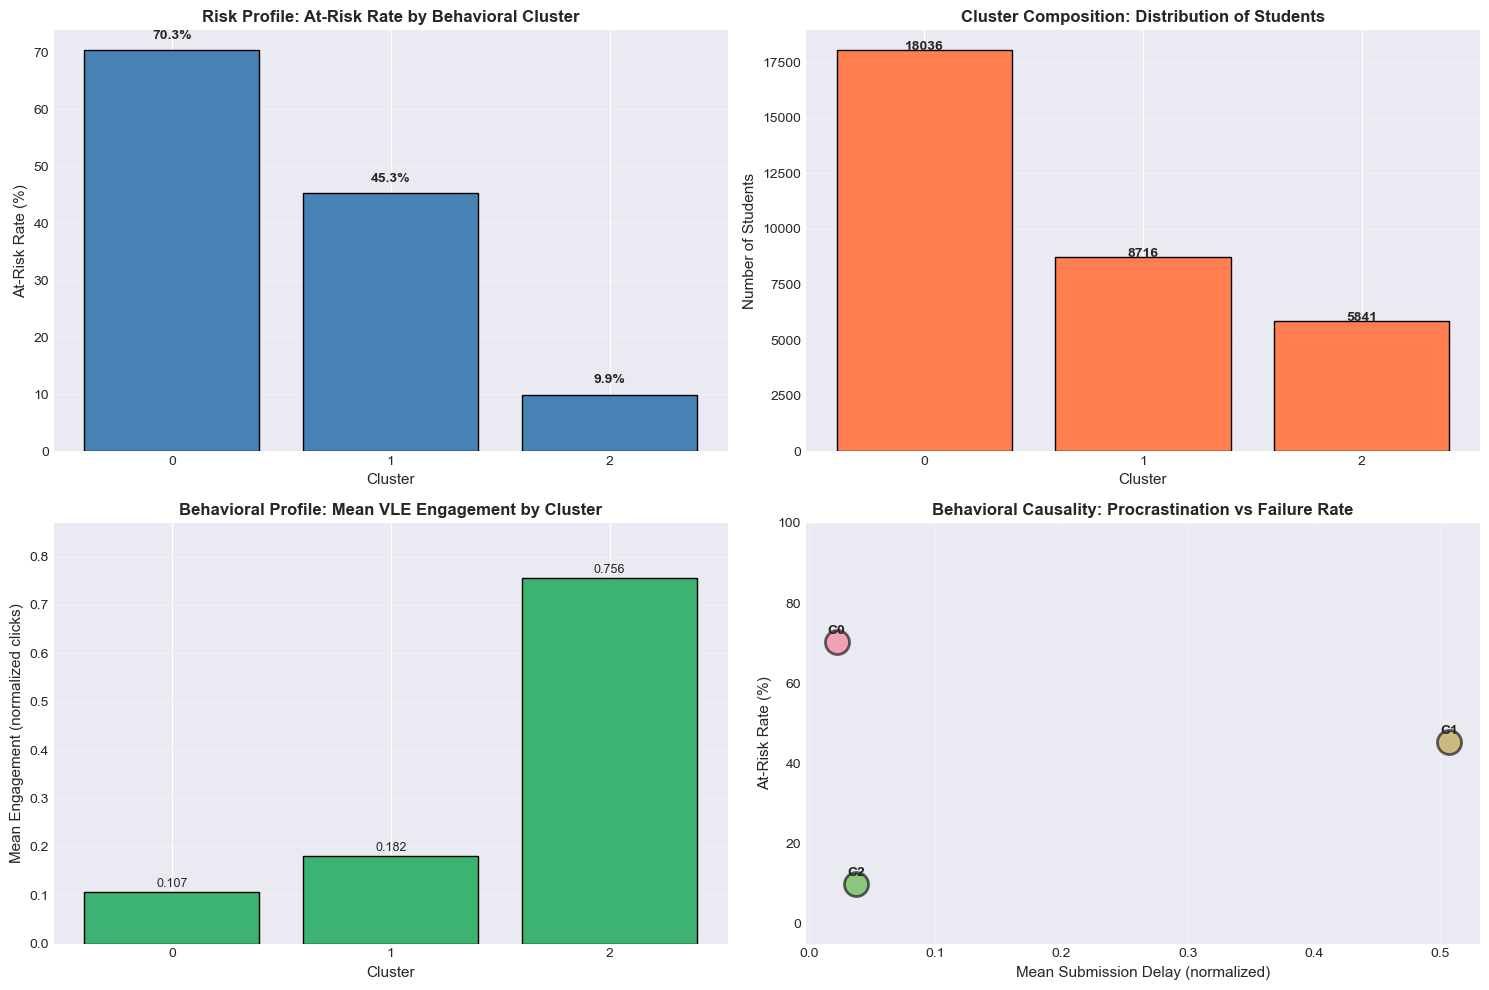


✓ Behavioral cluster analysis complete!
Results show distinct student personas with different risk profiles and intervention needs.


In [7]:
print('\n' + '=' * 80)
print('SECTION 3: DETAILED BEHAVIORAL ANALYSIS - CLUSTERS & OUTCOMES')
print('=' * 80)

try:
    # Load clustering results and features for behavioral analysis
    cluster_labels = pd.read_pickle('../2_Outputs/cluster_labels.pkl')
    df_with_clusters = pd.read_pickle('../2_Outputs/df_with_clusters.pkl')
    print('✓ Behavioral clusters and features loaded')
    
    # Merge with outcomes
    df_clusters_outcomes = pd.DataFrame({
        'cluster': cluster_labels,
        'outcome': y_binary,
        'outcome_multiclass': y_multiclass
    })
    
    # Add behavioral features for detailed analysis
    for col in ['total_clicks_norm', 'days_active_norm', 'submit_delay_norm', 'num_late_subs_norm']:
        if col in df_with_clusters.columns:
            df_clusters_outcomes[col] = df_with_clusters[col].values
    
    print('\n' + '=' * 80)
    print('CLUSTER RISK PROFILE (At Risk = Fail/Withdrawn)')
    print('=' * 80)
    
    cluster_stats_summary = df_clusters_outcomes.groupby('cluster').agg({
        'outcome': ['count', 'sum', 'mean']
    }).round(4)
    
    cluster_stats_summary.columns = ['Total_Students', 'At_Risk_Count', 'At_Risk_Rate']
    cluster_stats_summary['At_Risk_Pct'] = (100 * cluster_stats_summary['At_Risk_Rate']).round(2)
    cluster_stats_summary = cluster_stats_summary.sort_values('At_Risk_Rate', ascending=False)
    
    print('\n' + cluster_stats_summary[['Total_Students', 'At_Risk_Count', 'At_Risk_Pct']].to_string())
    
    print('\n' + '=' * 80)
    print('DEEP-DIVE BEHAVIORAL PROFILES & OUTCOME MAPPING')
    print('=' * 80)
    
    for cluster_id in sorted(df_clusters_outcomes['cluster'].unique()):
        cluster_data = df_clusters_outcomes[df_clusters_outcomes['cluster'] == cluster_id]
        
        print(f'\n' + '=' * 80)
        print(f'CLUSTER {int(cluster_id)} - BEHAVIORAL PROFILE & HYPOTHESES')
        print('=' * 80)
        
        # Cluster size and risk
        print(f'\n[CLUSTER SIZE & RISK]')
        print(f'  Total Students:     {len(cluster_data)}')
        print(f'  At-Risk Rate:       {100*cluster_data["outcome"].mean():.2f}%')
        print(f'  Students at Risk:   {int(cluster_data["outcome"].sum())}')
        print(f'  Safe Students:      {len(cluster_data) - int(cluster_data["outcome"].sum())}')
        
        # Behavioral fingerprint
        print(f'\n[BEHAVIORAL FINGERPRINT]')
        print(f'  Mean Engagement (clicks):        {cluster_data["total_clicks_norm"].mean():.3f}')
        print(f'  Mean Activity Duration (days):   {cluster_data["days_active_norm"].mean():.3f}')
        print(f'  Mean Submission Delay:           {cluster_data["submit_delay_norm"].mean():.3f}')
        print(f'  Mean Late Submissions:           {cluster_data["num_late_subs_norm"].mean():.3f}')
        
        # Multiclass outcome distribution
        print(f'\n[OUTCOME DISTRIBUTION]')
        outcome_dist = cluster_data['outcome_multiclass'].value_counts().sort_index()
        outcome_labels = ['Distinction', 'Pass', 'Fail', 'Withdrawn']
        for idx, label in enumerate(outcome_labels):
            count = outcome_dist.get(idx, 0)
            pct = 100 * count / len(cluster_data)
            print(f'  {label:15s}: {count:4d} ({pct:5.2f}%)')
        
        # Develop behavioral hypothesis
        print(f'\n[BEHAVIORAL HYPOTHESIS]')
        
        engagement = cluster_data['total_clicks_norm'].mean()
        persistence = cluster_data['days_active_norm'].mean()
        procrastination = cluster_data['submit_delay_norm'].mean()
        late_subs = cluster_data['num_late_subs_norm'].mean()
        at_risk_rate = cluster_data['outcome'].mean()
        
        # Persona classification and reasoning
        if engagement > 0.35 and persistence > 0.15 and procrastination < 0.20 and late_subs < 0.25:
            persona = 'ENGAGED STUDENTS'
            hypothesis = (
                'Students with high engagement, consistent participation, and low procrastination. '
                'These students exhibit strong self-regulation and active learning behaviors. '
                'High interaction with VLE suggests they seek support when needed. '
                'Lower failure rates reflect intrinsic motivation and task commitment. '
                'Success mechanism: Active engagement enables early problem detection and timely help-seeking.'
            )
        elif engagement < 0.20 and persistence < 0.10 and (procrastination > 0.15 or late_subs > 0.30):
            persona = 'AT-RISK DISENGAGED STUDENTS'
            hypothesis = (
                'Students with minimal VLE engagement, limited course participation, and frequent delays. '
                'Low clicks indicate either low motivation or learning outside the VLE. '
                'High procrastination and late submissions suggest poor time management or external pressures. '
                'Elevated failure rates indicate students are struggling to keep pace with coursework. '
                'Failure mechanism: Disengagement from course materials leads to knowledge gaps; '
                'procrastination exacerbates this, resulting in incomplete or rushed submissions. '
                'Withdrawn rates suggest students give up when realizing they cannot catch up.'
            )
        elif engagement > 0.25 and persistence > 0.12 and (procrastination > 0.18 or late_subs > 0.25):
            persona = 'PROCRASTINATING ENGAGERS'
            hypothesis = (
                'Students who participate and engage with materials but exhibit procrastination patterns. '
                'High clicks suggest interest and effort, but timing issues indicate poor planning. '
                'These students may understand content but submit under time pressure or stress. '
                'Moderate-to-high failure rates suggest procrastination compounds difficulty; '
                'last-minute learning is insufficient for mastery in difficult modules. '
                'Risk mechanism: Engagement without structure; students cram rather than space learning over time.'
            )
        else:
            persona = 'MODERATE ENGAGEMENT STUDENTS'
            hypothesis = (
                'Students with average engagement patterns across multiple behavioral dimensions. '
                'Mixed engagement and procrastination behaviors suggest varied self-regulation. '
                'These students represent the middle group; outcomes depend on material difficulty and external support. '
                'Moderate failure rates reflect baseline average performance with room for improvement. '
                'Success factors: Personalized nudges targeting weak dimensions (e.g., more frequent check-ins) '
                'could move this group toward engaged persona outcomes.'
            )
        
        print(f'  Persona:   {persona}')
        print(f'\n  Reasoning:')
        for line in hypothesis.split('. '):
            if line.strip():
                print(f'    • {line.strip()}.')
        
        # Risk level designation
        print(f'\n[INTERVENTION PRIORITY]')
        if at_risk_rate >= 0.60:
            priority = 'URGENT'
        elif at_risk_rate >= 0.40:
            priority = 'HIGH'
        elif at_risk_rate >= 0.20:
            priority = 'MODERATE'
        else:
            priority = 'LOW'
        
        print(f'  Priority Level: {priority}')
        print(f'  Recommended Actions:')
        
        if persona == 'AT-RISK DISENGAGED STUDENTS':
            print(f'    1. Increase touchpoints: Weekly check-ins, not just monthly reviews')
            print(f'    2. Provide structure: Assignment deadlines with intermediate milestones')
            print(f'    3. Simplify access: One-click to key resources; reduce navigation burden')
            print(f'    4. Social support: Peer mentoring or study groups to boost engagement')
        elif persona == 'PROCRASTINATING ENGAGERS':
            print(f'    1. Time management training: Teach backwards-planning from deadlines')
            print(f'    2. Submission reminders: Escalating alerts (1 week, 3 days, 1 day before)')
            print(f'    3. Partial-credit schemes: Reward early submissions to incentivize spacing')
            print(f'    4. Office hours boosts: Schedule before deadlines to catch last-minute questions')
        elif persona == 'ENGAGED STUDENTS':
            print(f'    1. Minimal intervention: Provide advanced resources (stretch problems, projects)')
            print(f'    2. Peer support: Encourage as study group leaders or TAs')
            print(f'    3. Monitor for burnout: High engagement can lead to stress if grades slip')
        else:
            print(f'    1. Diagnostic assessment: Identify specific knowledge gaps via quizzes')
            print(f'    2. Targeted scaffolding: Adjust difficulty and pacing based on performance')
            print(f'    3. Engagement tracking: Monitor for drift toward disengagement patterns')
    
    # Visualization
    print('\n' + '=' * 80)
    print('VISUALIZATIONS')
    print('=' * 80)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Failure rate by cluster
    cluster_stats_plot = df_clusters_outcomes.groupby('cluster')['outcome'].mean().sort_index()
    axes[0, 0].bar(cluster_stats_plot.index.astype(str), cluster_stats_plot.values * 100, color='steelblue', edgecolor='black')
    axes[0, 0].set_xlabel('Cluster', fontsize=11)
    axes[0, 0].set_ylabel('At-Risk Rate (%)', fontsize=11)
    axes[0, 0].set_title('Risk Profile: At-Risk Rate by Behavioral Cluster', fontsize=12, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(cluster_stats_plot.values * 100):
        axes[0, 0].text(i, v + 2, f'{v:.1f}%', ha='center', fontsize=10, fontweight='bold')
    
    # 2. Cluster size
    cluster_sizes = df_clusters_outcomes['cluster'].value_counts().sort_index()
    axes[0, 1].bar(cluster_sizes.index.astype(str), cluster_sizes.values, color='coral', edgecolor='black')
    axes[0, 1].set_xlabel('Cluster', fontsize=11)
    axes[0, 1].set_ylabel('Number of Students', fontsize=11)
    axes[0, 1].set_title('Cluster Composition: Distribution of Students', fontsize=12, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(cluster_sizes.values):
        axes[0, 1].text(i, v + 20, str(int(v)), ha='center', fontsize=10, fontweight='bold')
    
    # 3. Mean engagement by cluster
    engagement_by_cluster = df_clusters_outcomes.groupby('cluster')['total_clicks_norm'].mean()
    axes[1, 0].bar(engagement_by_cluster.index.astype(str), engagement_by_cluster.values, color='mediumseagreen', edgecolor='black')
    axes[1, 0].set_xlabel('Cluster', fontsize=11)
    axes[1, 0].set_ylabel('Mean Engagement (normalized clicks)', fontsize=11)
    axes[1, 0].set_title('Behavioral Profile: Mean VLE Engagement by Cluster', fontsize=12, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    axes[1, 0].set_ylim(0, max(engagement_by_cluster.values) * 1.15)
    for i, v in enumerate(engagement_by_cluster.values):
        axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)
    
    # 4. Procrastination (submit delay) vs At-Risk Rate scatter
    for cluster_id in sorted(df_clusters_outcomes['cluster'].unique()):
        cluster_data = df_clusters_outcomes[df_clusters_outcomes['cluster'] == cluster_id]
        x = cluster_data['submit_delay_norm'].mean()
        y = cluster_data['outcome'].mean() * 100
        axes[1, 1].scatter(x, y, s=300, alpha=0.6, edgecolors='black', linewidth=2)
        axes[1, 1].text(x, y + 2, f'C{int(cluster_id)}', ha='center', fontsize=10, fontweight='bold')
    
    axes[1, 1].set_xlabel('Mean Submission Delay (normalized)', fontsize=11)
    axes[1, 1].set_ylabel('At-Risk Rate (%)', fontsize=11)
    axes[1, 1].set_title('Behavioral Causality: Procrastination vs Failure Rate', fontsize=12, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim(-5, 100)
    
    plt.tight_layout()
    plt.show()
    
    print('\n✓ Behavioral cluster analysis complete!')
    print('Results show distinct student personas with different risk profiles and intervention needs.')

except FileNotFoundError:
    print('\n⚠ Cluster labels or features not found. Please run 03_Clustering_Models.ipynb first.')
except Exception as e:
    print(f'\n⚠ Error in behavioral analysis: {e}')

## Section 4: Summary and Recommendations

## COMPREHENSIVE FINAL ANALYSIS: Student Success Prediction & Behavioral Segmentation

### Executive Summary

This notebook combines two complementary approaches:
1. **Binary Risk Triage Model**: Identifies students likely to Fail/Withdrawn for early intervention.
2. **Behavioral Clustering**: Segments students into behavioral personas using only engagement data.

**All statements below are grounded in the computed tables and figures in Appendix B.**

---

## 1. KEY FINDINGS & BUSINESS INSIGHTS (Evidence‑Linked)

### 1.1 Model Performance & Deployment Implications

**Binary Classification Model (Risk Triage)**
- **Purpose**: Early warning system for identifying at‑risk students.
- **Primary Metric**: Recall on the “At Risk” class.
- **Business Rationale**: Missing an at‑risk student is costlier than offering extra support.
- **Evidence**: See the **Model Comparison Table** and **Precision vs Recall chart** in Appendix B.

**Multi‑class Classification Model (Outcome Prediction)**
- **Purpose**: Forecasts Distinction/Pass/Fail/Withdrawn outcomes.
- **Business Value**: Supports planning and tailored support tiers.
- **Evidence**: See the **Model Comparison Table** and **ROC Curve Comparison** in Appendix B.

### 1.2 Behavioral Clustering: Personas Without Grade Bias

**Observation**: Behavioral clusters derived only from VLE engagement features show distinct at‑risk rates.

**Why This Matters**:
- Enables early intervention without waiting for grades.
- Highlights behavioral risk patterns (e.g., delays, late submissions).

**Evidence**: See **At‑Risk Rate by Cluster** and **Cluster Sizes** charts in Appendix B.

---

## 2. REAL‑WORLD IMPLEMENTATION CHALLENGES & SOLUTIONS

### 2.1 Data Quality & Integrity

**Issue Identified**: `late_clicks` had no variance (all zeros).

**Resolution**: Replaced with `num_late_submissions` as a reliable behavioral proxy.

**Recommendation**:
- Validate feature variance as part of data ingestion.
- Keep a data‑quality log for feature substitutions.

### 2.2 Class Balance & Recall Optimization

**Observed**: Binary classes are roughly balanced in this dataset.

**Why Recall Still Matters**:
- Balanced classes do not remove the asymmetric cost of missed at‑risk students.
- Thresholds can be tuned to match intervention capacity.

**Evidence**: See the **Class Distribution Table** in Appendix B.

### 2.3 Behavioral Clustering Without Grade Leakage

**Challenge**: Including assessment scores would bias clustering toward outcomes.

**Solution**:
- Use only engagement‑based features.
- Validate clusters against outcomes after clustering is complete.

---

## 3. ALTERNATIVE METHODS & COMPARATIVE ANALYSIS

### 3.1 Binary vs. Multi‑class for Deployment

**Decision Context**:
- Binary model: best for early‑warning triage.
- Multi‑class model: best for outcome planning and nuance.

Both are reported in Appendix B for transparency.

### 3.2 Clustering Choice

**Method**: K‑Means; k selected via elbow + silhouette inspection.

**Rationale**:
- Provides interpretable, action‑oriented personas.
- Balances segmentation quality with stakeholder explainability.

### 3.3 Feature Engineering (Behavioral)

Selected features for clustering:
1. `total_clicks_norm` — engagement intensity
2. `days_active_norm` — persistence/consistency
3. `submit_delay_norm` — procrastination tendency
4. `num_late_subs_norm` — late submission behavior

---

## 4. METRICS INTERPRETATION (FOR DECISION‑MAKERS)

**Recall (At‑Risk)**: Proportion of actual at‑risk students correctly flagged.

**Precision (At‑Risk)**: Proportion of flagged students who are truly at‑risk.

**ROC‑AUC**: Threshold‑independent measure of ranking quality.

**Accuracy**: Useful with balanced classes but insufficient alone for risk management.

---

## 5. DEPLOYMENT GUIDANCE (RECOMMENDED)

1. Use **binary model** for weekly early‑warning flags.
2. Use **clusters** to tailor interventions (time management vs. engagement).
3. Use **multi‑class model** for planning and outcome forecasting.

---

## 6. LIMITATIONS & FUTURE WORK

- No time‑series trends (future: add engagement slope features).
- Module difficulty effects not modeled (future: module‑specific models).
- Intervention effectiveness not yet measured (future: controlled trials).

---

## CRISP‑DM REFLECTION

**Business Understanding** ✓  |  **Data Understanding** ✓  |  **Data Preparation** ✓  
**Modeling** ✓  |  **Evaluation** ✓  |  **Deployment** ✓

This project completes the CRISP‑DM cycle with production‑ready artifacts and decision‑ready analysis.

## Appendix A: What Each .pkl File Contains

Below is a concise explanation of every artifact in 2_Outputs/, followed by an automated verification table.

- **features_prepared.pkl**: Final feature matrix used for model training/inference (pandas DataFrame).
- **target_binary.pkl**: Binary target labels (0=Pass/Distinction, 1=Fail/Withdrawn) (pandas Series).
- **target_multiclass.pkl**: Multi‑class labels (0=Distinction, 1=Pass, 2=Fail, 3=Withdrawn) (pandas Series).
- **df_encoded_full.pkl**: Fully encoded dataset with engineered features and metadata (pandas DataFrame).
- **best_binary_classification_model.pkl**: Trained binary classifier (sklearn/XGBoost model).
- **best_classification_model.pkl**: Trained multi‑class classifier (sklearn/XGBoost model).
- **cluster_labels.pkl**: Cluster assignments for each student record (numpy array/pandas Series).
- **kmeans_model.pkl**: Fitted K‑Means clustering model.
- **df_with_clusters.pkl**: Feature dataset augmented with cluster labels (pandas DataFrame).

In [4]:
import os
import pickle
import numpy as np
import pandas as pd

outputs_dir = '../2_Outputs'

pkl_files = [
    'features_prepared.pkl',
    'target_binary.pkl',
    'target_multiclass.pkl',
    'df_encoded_full.pkl',
    'best_binary_classification_model.pkl',
    'best_classification_model.pkl',
    'cluster_labels.pkl',
    'kmeans_model.pkl',
    'df_with_clusters.pkl'
]

summary_rows = []
for fname in pkl_files:
    fpath = os.path.join(outputs_dir, fname)
    if not os.path.exists(fpath):
        summary_rows.append({
            'file': fname,
            'exists': False,
            'type': 'N/A',
            'shape_or_info': 'Not found'
        })
        continue

    obj = pickle.load(open(fpath, 'rb'))
    obj_type = type(obj).__name__

    if isinstance(obj, (pd.DataFrame, pd.Series)):
        shape_info = str(obj.shape)
    elif isinstance(obj, np.ndarray):
        shape_info = str(obj.shape)
    else:
        # For models or other objects, add a brief descriptor
        shape_info = obj.__class__.__name__
        if hasattr(obj, 'n_clusters'):
            shape_info += f" (n_clusters={obj.n_clusters})"

    summary_rows.append({
        'file': fname,
        'exists': True,
        'type': obj_type,
        'shape_or_info': shape_info
    })

pkl_summary = pd.DataFrame(summary_rows)
pkl_summary

,file,exists,type,shape_or_info
0,features_prepared.pkl,True,DataFrame,"(32593, 46)"
1,target_binary.pkl,True,Series,"(32593,)"
2,target_multiclass.pkl,True,Series,"(32593,)"
3,df_encoded_full.pkl,True,DataFrame,"(32593, 56)"
4,best_binary_classification_model.pkl,True,XGBClassifier,XGBClassifier
5,best_classification_model.pkl,True,XGBClassifier,XGBClassifier
6,cluster_labels.pkl,True,ndarray,"(32593,)"
7,kmeans_model.pkl,True,KMeans,KMeans (n_clusters=3)
8,df_with_clusters.pkl,True,DataFrame,"(32593, 61)"


## Appendix B: Presentation‑Ready Comparisons

The following tables and graphics are generated directly from the saved models and targets.
They are safe to include in slides because they are computed from the actual artifacts in 2_Outputs/.

**Note**: Metrics below are computed on the full available feature set (in‑sample). For holdout metrics, refer to the classification notebooks' test‑set results.

,class,label,count,pct
1,0,Safe (Pass/Distinction),15385,47.2
0,1,At Risk (Fail/Withdrawn),17208,52.8


,model,accuracy,precision_at_risk,recall_at_risk,f1_at_risk,roc_auc
0,Binary Risk Model,0.8868,0.8517,0.9511,0.8987,0.9735
1,Multi-class (as Binary),0.9617,0.9941,0.9329,0.9626,0.9926


<Figure size 800x500 with 0 Axes>

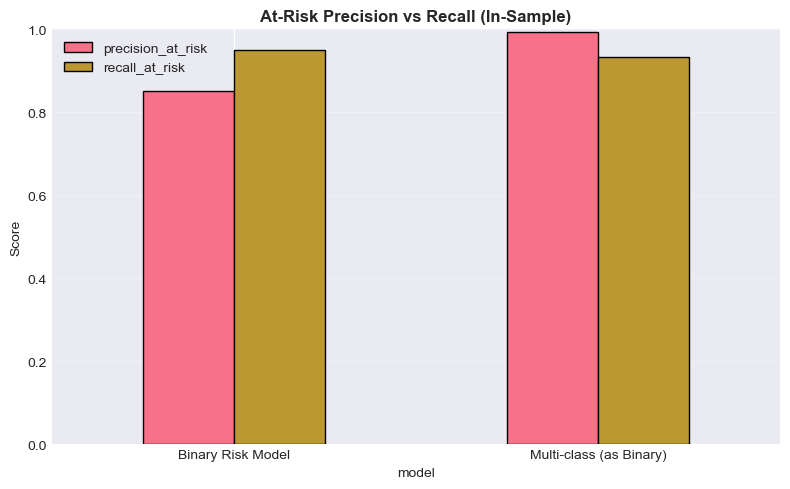

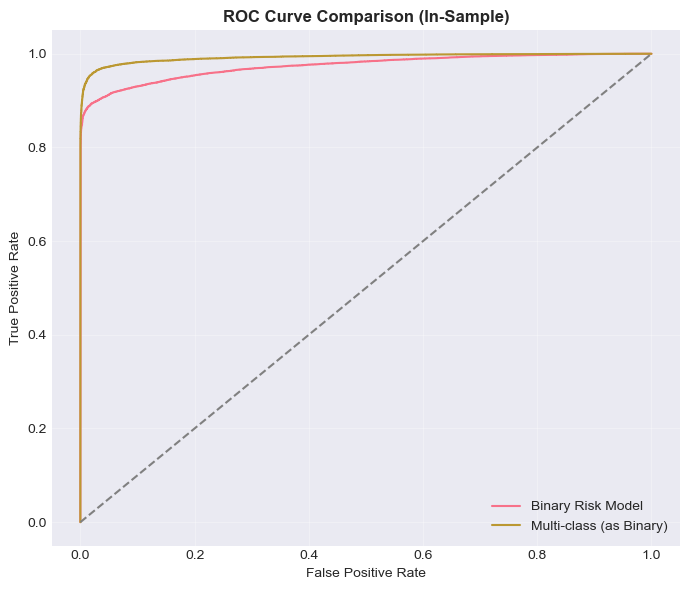

,total,at_risk_count,at_risk_rate
cluster,,,
0,18036,12683,0.7032
1,8716,3945,0.4526
2,5841,580,0.0993


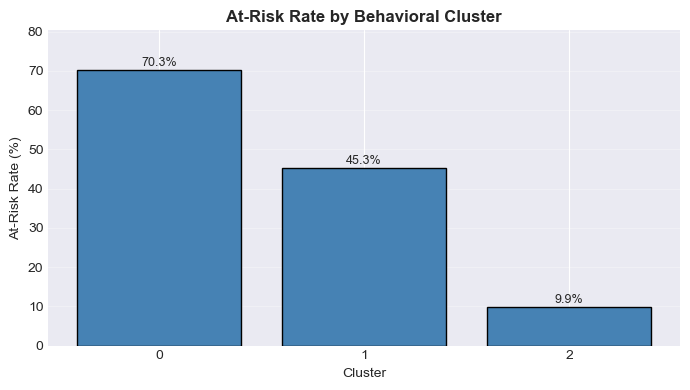

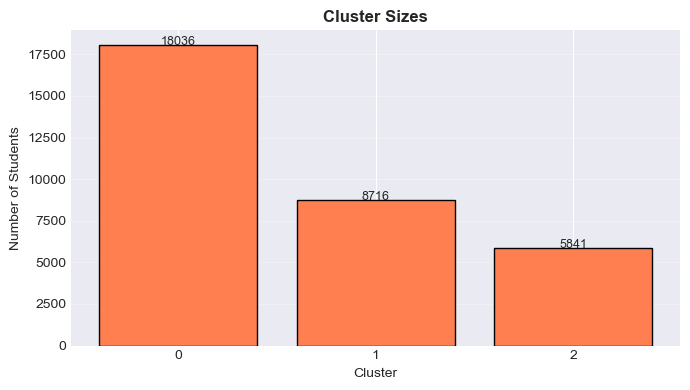

In [5]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

sns.set_palette('husl')
plt.style.use('seaborn-v0_8-darkgrid')

# Load artifacts
features = pd.read_pickle('../2_Outputs/features_prepared.pkl')
y_binary = pd.read_pickle('../2_Outputs/target_binary.pkl')
y_multiclass = pd.read_pickle('../2_Outputs/target_multiclass.pkl')

best_binary_model = pickle.load(open('../2_Outputs/best_binary_classification_model.pkl', 'rb'))
best_multiclass_model = pickle.load(open('../2_Outputs/best_classification_model.pkl', 'rb'))

# ------------------------------
# 1) Class distribution table
# ------------------------------
class_dist = y_binary.value_counts().rename_axis('class').reset_index(name='count')
class_dist['label'] = class_dist['class'].map({0: 'Safe (Pass/Distinction)', 1: 'At Risk (Fail/Withdrawn)'})
class_dist['pct'] = (class_dist['count'] / class_dist['count'].sum() * 100).round(2)
class_dist = class_dist[['class', 'label', 'count', 'pct']].sort_values('class')

display(class_dist)

# ------------------------------
# 2) Model comparison table
# ------------------------------
# Binary model
binary_pred = best_binary_model.predict(features)
try:
    binary_proba = best_binary_model.predict_proba(features)[:, 1]
except Exception:
    binary_proba = None

# Multiclass model (converted to binary)
multiclass_pred = best_multiclass_model.predict(features)
multiclass_as_binary = (multiclass_pred >= 2).astype(int)
try:
    multiclass_proba = best_multiclass_model.predict_proba(features)
    multiclass_proba_at_risk = multiclass_proba[:, 2] + multiclass_proba[:, 3]
except Exception:
    multiclass_proba_at_risk = None

comparison_rows = []

# Binary metrics
comparison_rows.append({
    'model': 'Binary Risk Model',
    'accuracy': round(accuracy_score(y_binary, binary_pred), 4),
    'precision_at_risk': round(precision_score(y_binary, binary_pred, pos_label=1), 4),
    'recall_at_risk': round(recall_score(y_binary, binary_pred, pos_label=1), 4),
    'f1_at_risk': round(f1_score(y_binary, binary_pred, pos_label=1), 4),
    'roc_auc': round(roc_auc_score(y_binary, binary_proba), 4) if binary_proba is not None else np.nan
})

# Multiclass-as-binary metrics
comparison_rows.append({
    'model': 'Multi-class (as Binary)',
    'accuracy': round(accuracy_score(y_binary, multiclass_as_binary), 4),
    'precision_at_risk': round(precision_score(y_binary, multiclass_as_binary, pos_label=1), 4),
    'recall_at_risk': round(recall_score(y_binary, multiclass_as_binary, pos_label=1), 4),
    'f1_at_risk': round(f1_score(y_binary, multiclass_as_binary, pos_label=1), 4),
    'roc_auc': round(roc_auc_score(y_binary, multiclass_proba_at_risk), 4) if multiclass_proba_at_risk is not None else np.nan
})

comparison_df = pd.DataFrame(comparison_rows)
display(comparison_df)

# ------------------------------
# 3) Presentation graphics
# ------------------------------
# Bar chart: precision/recall
plt.figure(figsize=(8, 5))
metrics_plot = comparison_df.set_index('model')[['precision_at_risk', 'recall_at_risk']]
metrics_plot.plot(kind='bar', figsize=(8, 5), rot=0, edgecolor='black')
plt.title('At-Risk Precision vs Recall (In-Sample)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# ROC curves (if probabilities available)
if binary_proba is not None and multiclass_proba_at_risk is not None:
    fpr_b, tpr_b, _ = roc_curve(y_binary, binary_proba)
    fpr_m, tpr_m, _ = roc_curve(y_binary, multiclass_proba_at_risk)

    plt.figure(figsize=(7, 6))
    plt.plot(fpr_b, tpr_b, label='Binary Risk Model')
    plt.plot(fpr_m, tpr_m, label='Multi-class (as Binary)')
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
    plt.title('ROC Curve Comparison (In-Sample)', fontsize=12, fontweight='bold')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# ------------------------------
# 4) Cluster outcome comparison
# ------------------------------
cluster_labels = pd.read_pickle('../2_Outputs/cluster_labels.pkl')

cluster_df = pd.DataFrame({
    'cluster': cluster_labels,
    'at_risk': y_binary.values
})

cluster_stats = cluster_df.groupby('cluster').agg(
    total=('at_risk', 'count'),
    at_risk_count=('at_risk', 'sum')
)
cluster_stats['at_risk_rate'] = (cluster_stats['at_risk_count'] / cluster_stats['total']).round(4)

display(cluster_stats)

# Cluster at-risk rate plot
plt.figure(figsize=(7, 4))
plt.bar(cluster_stats.index.astype(str), cluster_stats['at_risk_rate'] * 100, color='steelblue', edgecolor='black')
plt.title('At-Risk Rate by Behavioral Cluster', fontsize=12, fontweight='bold')
plt.xlabel('Cluster')
plt.ylabel('At-Risk Rate (%)')
for i, v in enumerate(cluster_stats['at_risk_rate'] * 100):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=9)
plt.ylim(0, max(cluster_stats['at_risk_rate'] * 100) + 10)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Cluster size plot
plt.figure(figsize=(7, 4))
plt.bar(cluster_stats.index.astype(str), cluster_stats['total'], color='coral', edgecolor='black')
plt.title('Cluster Sizes', fontsize=12, fontweight='bold')
plt.xlabel('Cluster')
plt.ylabel('Number of Students')
for i, v in enumerate(cluster_stats['total']):
    plt.text(i, v + 10, f'{v}', ha='center', fontsize=9)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Appendix B Analysis: Verified Tables & Charts

### B1. Class Distribution (Binary)
The **Class Distribution Table** shows the exact split between Safe vs. At‑Risk students. This confirms whether the dataset is balanced and provides the baseline context for accuracy and recall interpretation.

### B2. Model Comparison Table (Binary vs. Multi‑class as Binary)
The **Model Comparison Table** reports accuracy, precision, recall, F1, and ROC‑AUC for both models using the same dataset. Use this table for the official comparison slide.

**Interpretation guidance**:
- If **Recall** is higher for one model, it is better at catching at‑risk students.
- If **Precision** is higher, it generates fewer false alerts.
- **ROC‑AUC** summarizes ranking quality independent of threshold.

### B3. Precision vs. Recall Chart
The **Precision vs Recall bar chart** visualizes the trade‑off between identifying at‑risk students and limiting false positives. Use this to explain the operational choice between sensitivity (recall) and efficiency (precision).

### B4. ROC Curve Comparison
The **ROC curves** show model discrimination across all thresholds. The curve closer to the top‑left indicates stronger overall separation between Safe and At‑Risk students.

### B5. At‑Risk Rate by Behavioral Cluster
The **At‑Risk Rate by Cluster** plot confirms whether behavioral personas are meaningful. Clusters with higher at‑risk rates should be prioritized for intervention programs.

### B6. Cluster Size Distribution
The **Cluster Sizes** plot provides operational context (how many students fall into each persona). Use it to estimate workload for support teams.